In [25]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Flatten
from keras.layers import Bidirectional
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

mpl.rcParams['figure.figsize'] = (20, 6)
mpl.rcParams['axes.grid'] = False

,temperatura,suma opadów,wilgotność,prędkość wiatru,zachmurzenine,day_number_in_year,PM2.5
0,0.3,0.0,94.5,0.7,7.3,1,94.0
1,-1.5,0.0,89.5,1.0,4.3,2,135.0
2,2.0,0.0,88.5,0.3,1.7,3,172.0
3,2.7,1.7,88.5,0.3,6.0,4,135.0
4,7.0,0.9,87.8,0.7,7.0,5,68.0
...,...,...,...,...,...,...,...
3482,22.2,0.5,85.3,0.7,3.7,239,9.9
3483,19.7,0.1,89.5,1.7,8.0,240,8.4
3484,21.0,0.9,89.0,1.0,7.7,241,10.2
3485,18.5,0.3,89.5,1.3,7.7,242,8.4


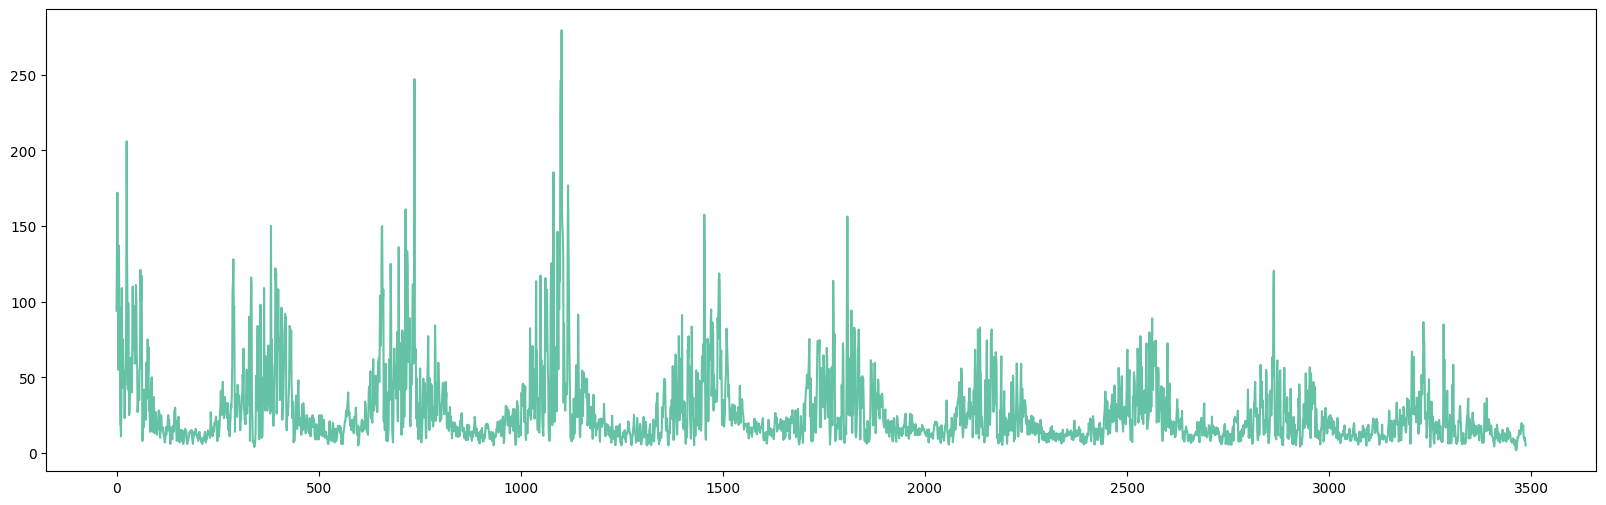

In [26]:

model_data = pd.read_csv("../../przygotowanie_danych/model_data.csv")
df2 = model_data.drop(model_data.columns[[0,1,2,3,4]],axis = 1)
model_data = df2
model_data.describe()
PM = model_data['PM2.5']
PM.plot()
model_data

In [27]:

X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y = model_data[['PM2.5']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.04, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.25, random_state=42,shuffle=False)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.transform(X_test)



print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)


y_train = y_train['PM2.5']
y_test = y_test['PM2.5']
y_val = y_val['PM2.5']

(3347, 6)
(105, 6)
(35, 6)


In [28]:
from sklearn.metrics import mean_squared_error as mse
def plot_predictions1(model, X, y, start=0, end=X_test_scaled.shape[0]):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end],color='r')
  plt.plot(df['Actuals'][start:end],color='c')
  print(mse(predictions, y))
  return mse(predictions, y)


In [30]:

early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

input_dim = X_train_scaled.shape[1]

model = Sequential()
model.add(Conv1D(64, kernel_size=6, activation='relu', input_shape=(1,6), padding='same'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2, padding='same'))
model.add(LSTM(64, activation='relu',input_shape=(1, 6), return_sequences=True))
model.add(LSTM(128, return_sequences=False))
# model.add(LSTM(256, return_sequences=False))
# model.add(LSTM(128, return_sequences=False))
model.add(LSTM(64, return_sequences=False))
model.add(LSTM(48, return_sequences=False))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()

cp = ModelCheckpoint('model20/', save_best_only=True, monitor='val_loss')
cp_loss = ModelCheckpoint('model21/', save_best_only=True, monitor='loss')
model.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.Huber(), metrics='mse')  
model.fit(X_train_scaled.reshape((X_train_scaled.shape[0], 1, 6)), y_train, 
          validation_data=(X_val_scaled.reshape((X_val_scaled.shape[0], 1, 6)), y_val),
          epochs=1000, callbacks=[cp,cp_loss,early_stopping])




Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1, 64)             2368      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 128)            24704     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 1, 128)            0         
 g1D)                                                            
                                                                 
 lstm_18 (LSTM)              (None, 1, 64)             49408     
                                                                 
 lstm_19 (LSTM)              (None, 1, 128)           

KeyboardInterrupt: 

2/2 [==============================] - 1s 4ms/step


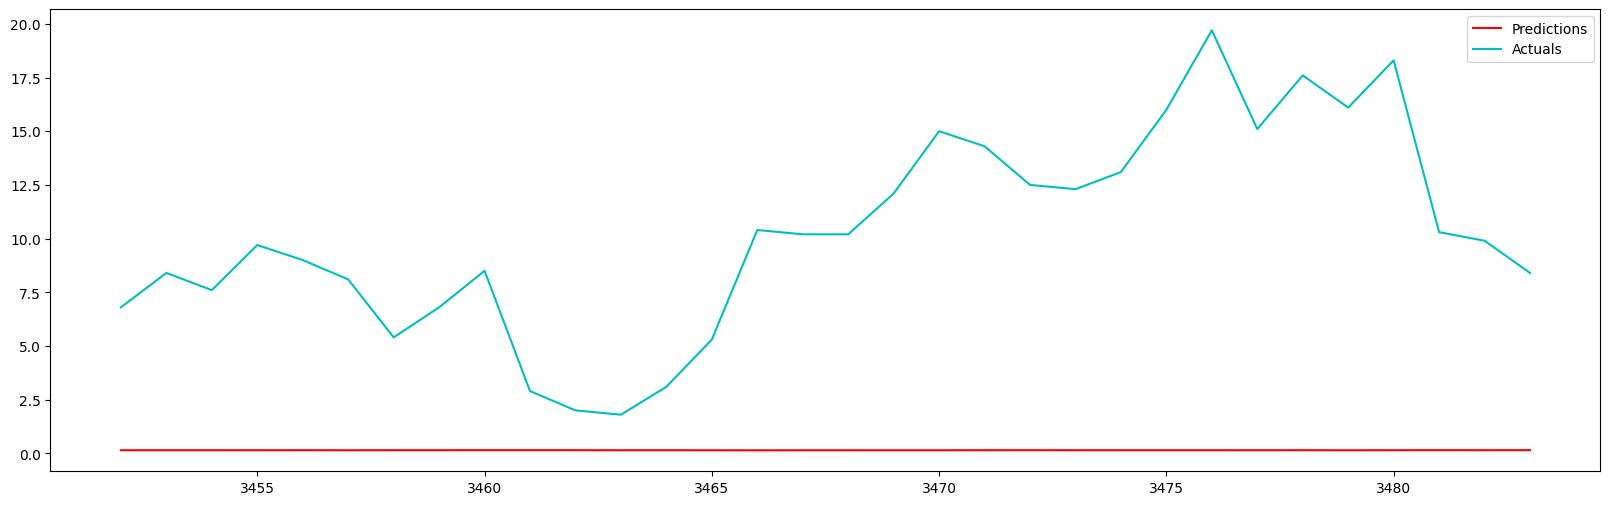

105/105 [==============================] - 0s 4ms/step


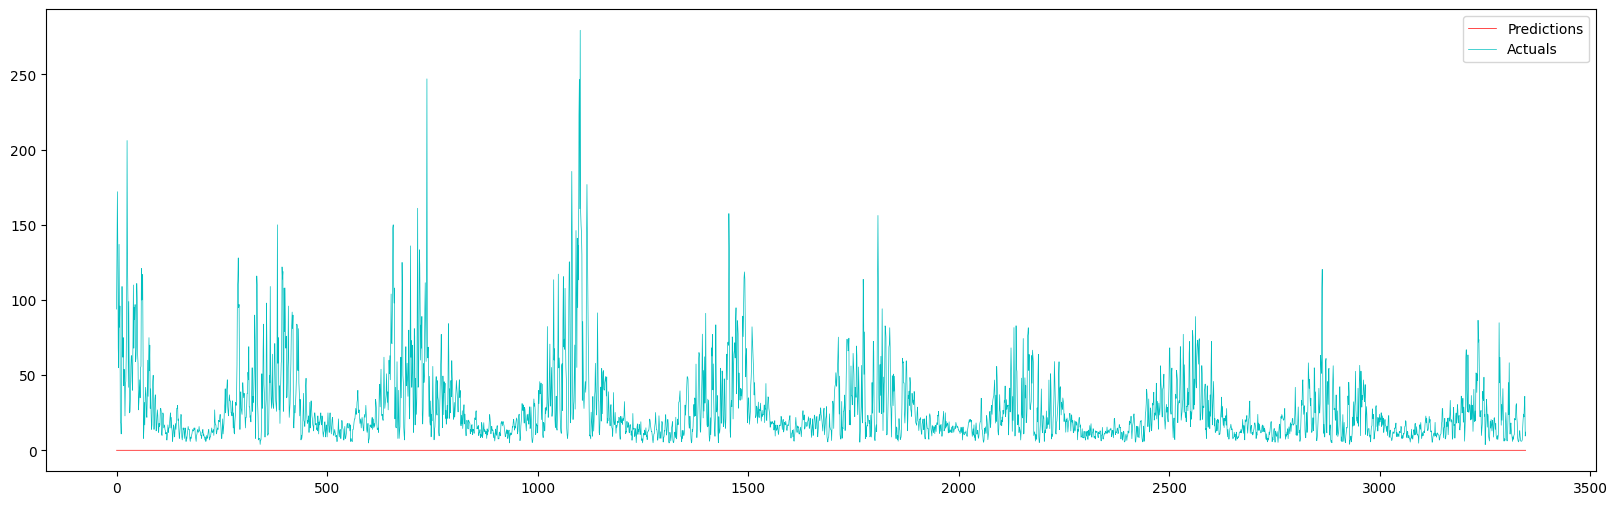

4/4 [==============================] - 0s 9ms/step


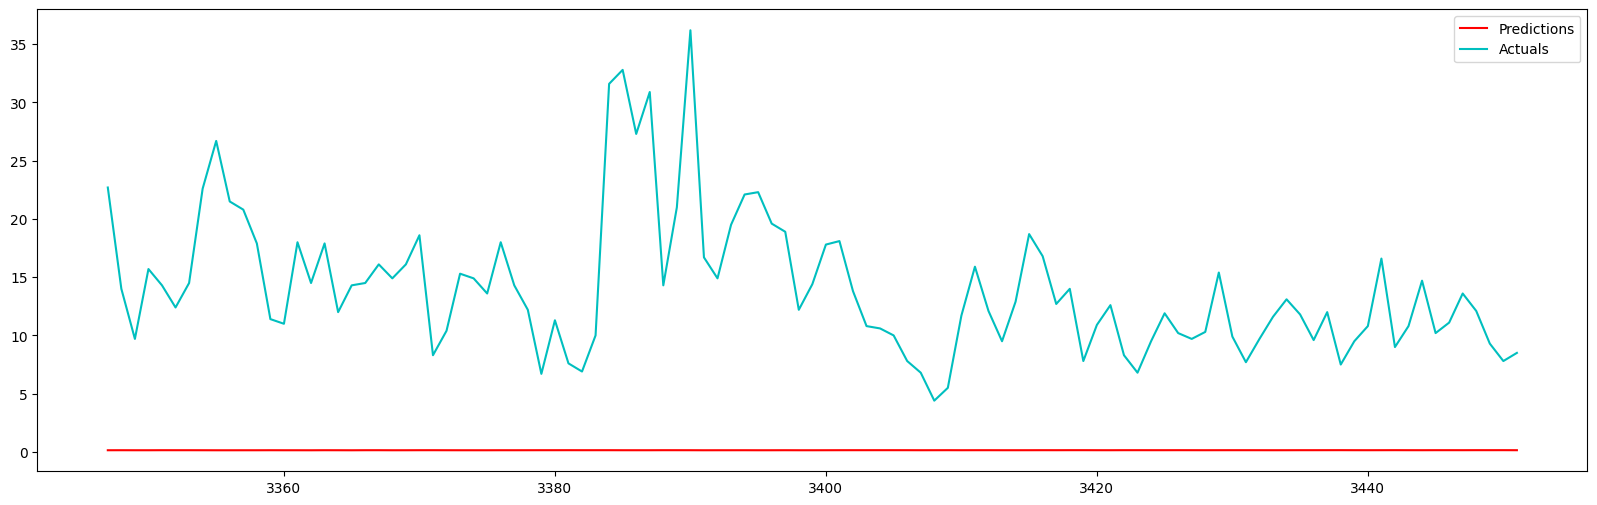

228.10749769712916
1/1 [==============================] - 0s 22ms/step


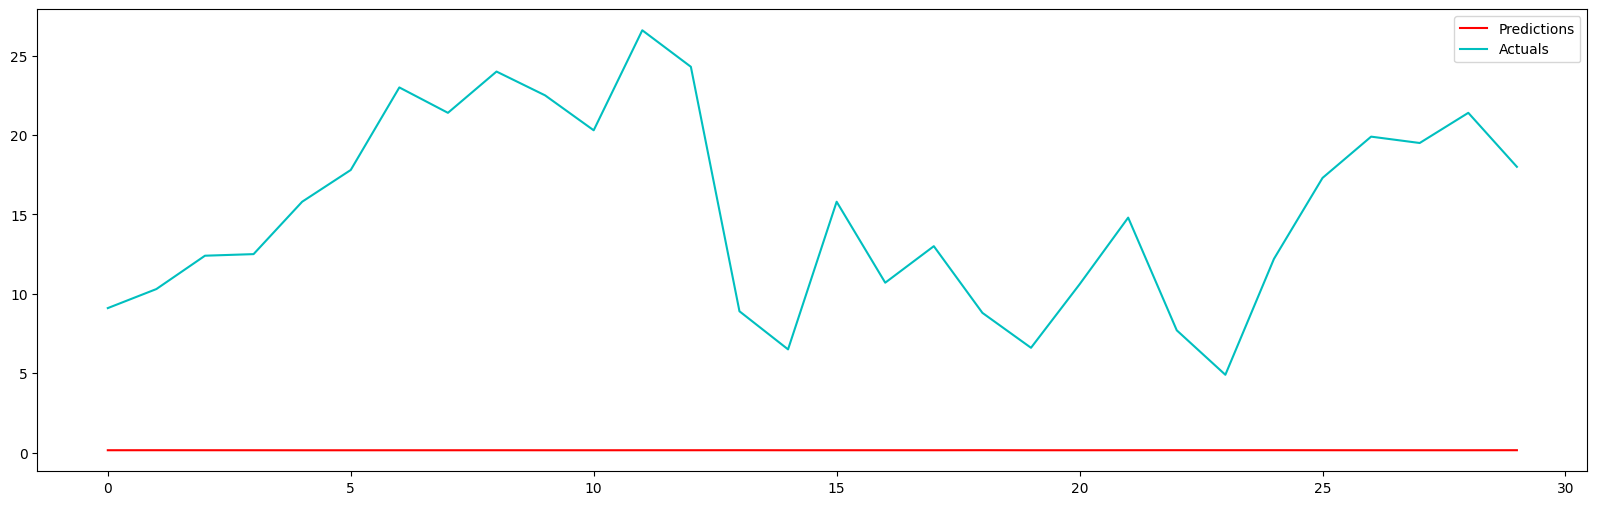

Procent dobrze przewidzianych: 33.33%


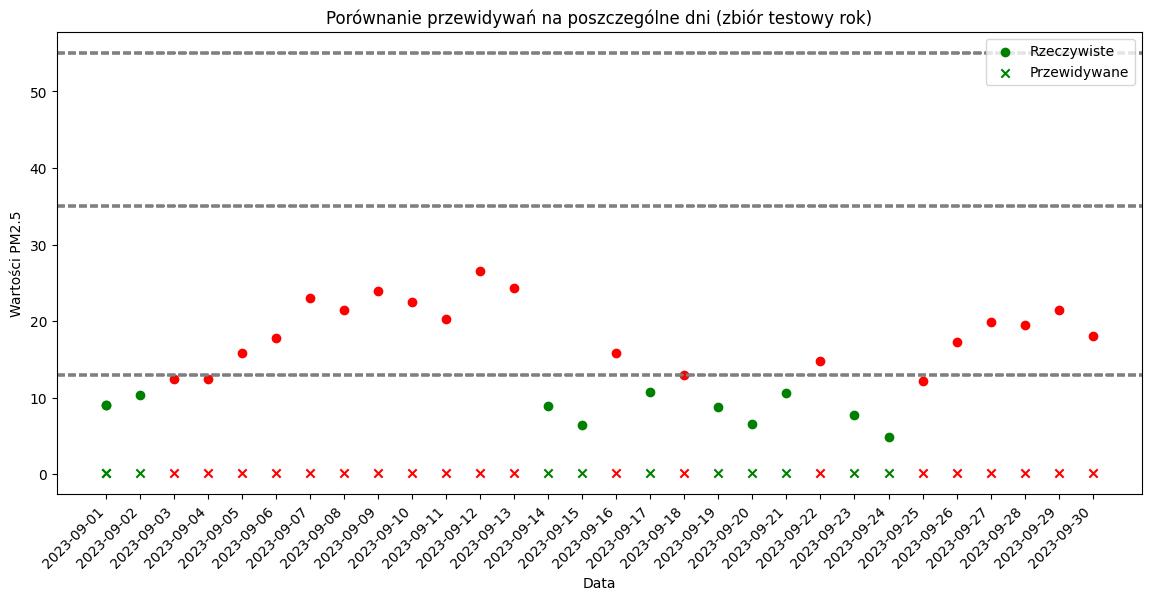

skuteczność:


In [22]:
from tensorflow.keras.models import load_model
loaded_model = load_model('model20/')

plot_predictions1(loaded_model, X_test_scaled.reshape((X_test_scaled.shape[0], 1, input_dim)), y_test)

plt.show()


predictions = loaded_model.predict(X_train_scaled.reshape((X_train_scaled.shape[0], 1, 6))).flatten()
df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y_train})
plt.plot(df['Predictions'][0:3347], label='Predictions',color='r',linewidth=0.5)
plt.plot(df['Actuals'][0:3347], label='Actuals',color='c',linewidth=0.5)
plt.legend()
plt.show()
predictions = loaded_model.predict(X_val_scaled.reshape((X_val_scaled.shape[0], 1, 6))).flatten()
df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y_val})
plt.plot(df['Predictions'][0:105], label='Predictions',color='r')
plt.plot(df['Actuals'][0:105], label='Actuals',color='c')
plt.legend()
plt.show()
print(mse(predictions, y_val))

def plot_predictions1(model, X, y, start=0, end=32):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end], label='Predictions',color='r')
  plt.plot(df['Actuals'][start:end], label='Actuals',color='c')

  plt.legend()
  plt.show()
  return df, mse(predictions, y)


model_data_test = pd.read_csv("../../przygotowanie_danych/model_data_test.csv")
df2 = model_data_test.drop(model_data_test.columns[[0,1,2,3,4]],axis = 1)
model_data_test = df2
model_data_test.describe()
model_data_test

X_test_test = model_data_test[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y_test_test = model_data_test['PM2.5']

X_test_test_scaled = scaler.transform(X_test_test)

predictions = loaded_model.predict(X_test_test_scaled.reshape((X_test_test_scaled.shape[0], 1, 6))).flatten()
df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y_test_test})
plt.plot(df['Predictions'][0:3347], label='Predictions',color='r')
plt.plot(df['Actuals'][0:3347], label='Actuals',color='c')
plt.legend()
plt.show()




def ocen_jakosc_powietrza(rzeczywiste, przewidywane):
    prog_bardzo_dobry = 12
    prog_dobry = 35
    prog_umiarkowany = 55
    prog_dostateczny = 75
    prog_zly = 110

    kategorie = {
        'bardzo_dobry': (0, prog_bardzo_dobry),
        'dobry': (prog_bardzo_dobry + 0.1, prog_dobry),
        'umiarkowany': (prog_dobry + 0.1, prog_umiarkowany),
        'dostateczny': (prog_umiarkowany + 0.1, prog_dostateczny),
        'zly': (prog_dostateczny + 0.1, prog_zly),
        'bardzo_zly': (prog_zly + 0.1, float('inf'))
    }

    def przyporzadkuj_kategorie(wartosc):
        for kategoria, (min_prog, max_prog) in kategorie.items():
            if min_prog <= wartosc <= max_prog:
                return kategoria

    rzeczywista_kategoria = przyporzadkuj_kategorie(rzeczywiste)
    przewidziana_kategoria = przyporzadkuj_kategorie(przewidywane)

    return rzeczywista_kategoria, przewidziana_kategoria


# Przykładowe dane - zastąp tym odpowiednimi danymi
results = pd.DataFrame({
    'Data': pd.date_range(start='2023-09-01', periods=30),
    'Rzeczywiste wartości (y_test)': y_test_test,
    'Przewidywane wartości (y_pred)': predictions
})

# Dodaj kolumny kategorii i porównania
results['Rzeczywista kategoria'], results['Przewidziana kategoria'] = zip(*results.apply(lambda row: ocen_jakosc_powietrza(row['Rzeczywiste wartości (y_test)'], row['Przewidywane wartości (y_pred)']), axis=1))
results['Zgadza się'] = results['Rzeczywista kategoria'] == results['Przewidziana kategoria']
legend_added = False  # Dodaj legendę tylko raz

# Wyodrębnij unikalne daty
unikalne_daty = results['Data'].unique()


procent_poprawnych = results['Zgadza się'].mean() * 100
print(f"Procent dobrze przewidzianych: {procent_poprawnych:.2f}%")


plt.figure(figsize=(14, 6))
sns.set_palette("Set2")  # Wybierz zestaw kolorów
for data in unikalne_daty:
    dane_dnia = results[results['Data'] == data]
    color = 'green' if dane_dnia['Zgadza się'].all() else 'red'
    
    
    if not legend_added:
        
        plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'],label='Rzeczywiste', color=color, marker='o')
        plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'], label='Przewidywane',color=color, marker='x')
        legend_added = True

    plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'], color=color, marker='o')
    plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'],color=color, marker='x')

    progi_jakosci_powietrza = [13, 35, 55]
    for prog in progi_jakosci_powietrza:
        plt.axhline(y=prog, color='gray', linestyle='--')
plt.legend(loc='upper right')
plt.title('Porównanie przewidywań na poszczególne dni (zbiór testowy rok)')
plt.xlabel('Data')
plt.ylabel('Wartości PM2.5')
plt.xticks(ticks=unikalne_daty, labels=[data.strftime('%Y-%m-%d') for data in unikalne_daty], rotation=45, ha='right')
plt.show()
print("skuteczność:",)




2/2 [==============================] - 1s 3ms/step


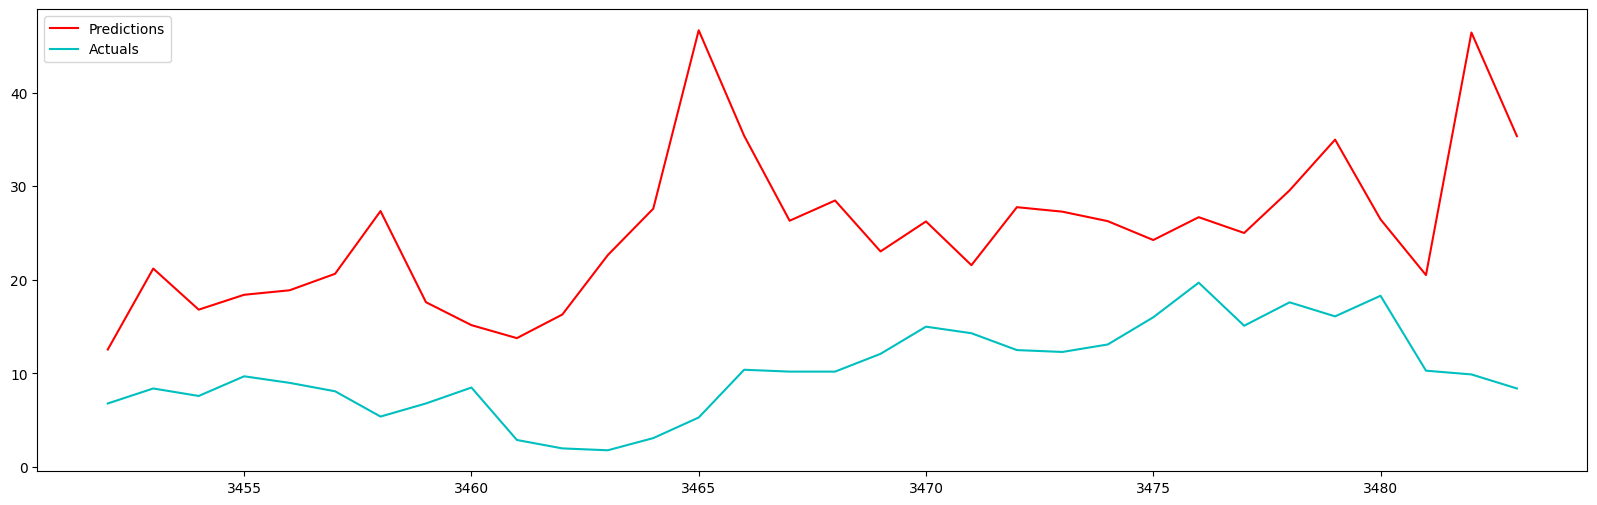

105/105 [==============================] - 0s 3ms/step


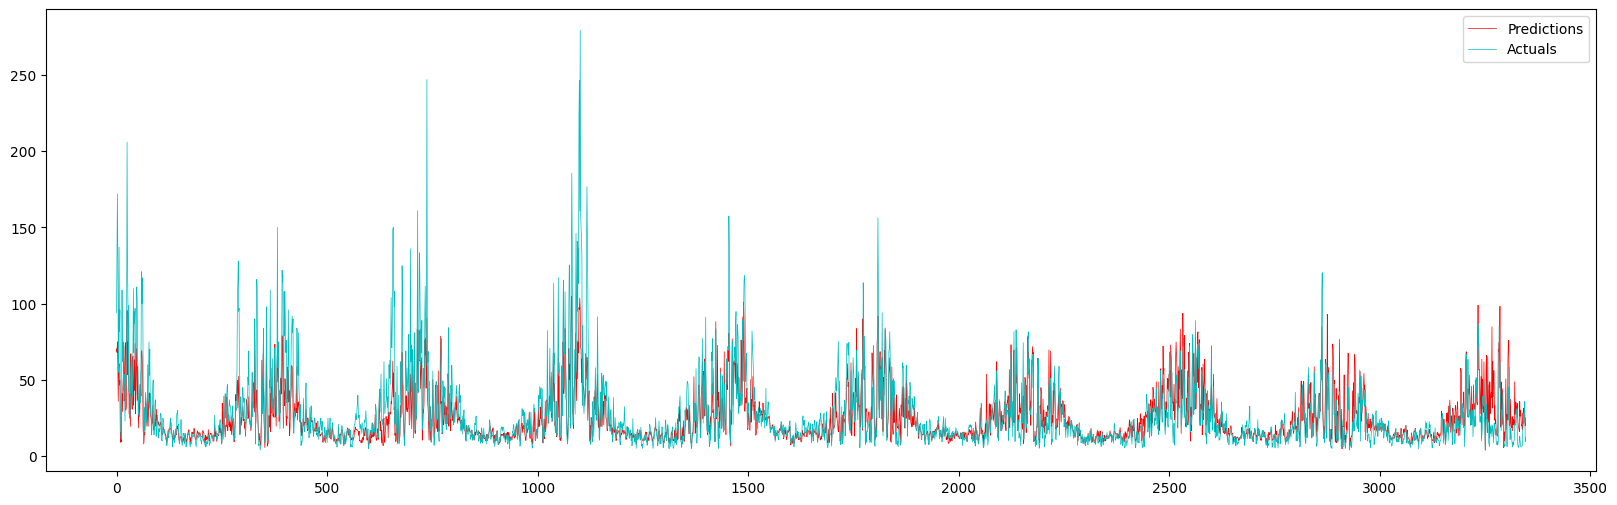

4/4 [==============================] - 0s 3ms/step


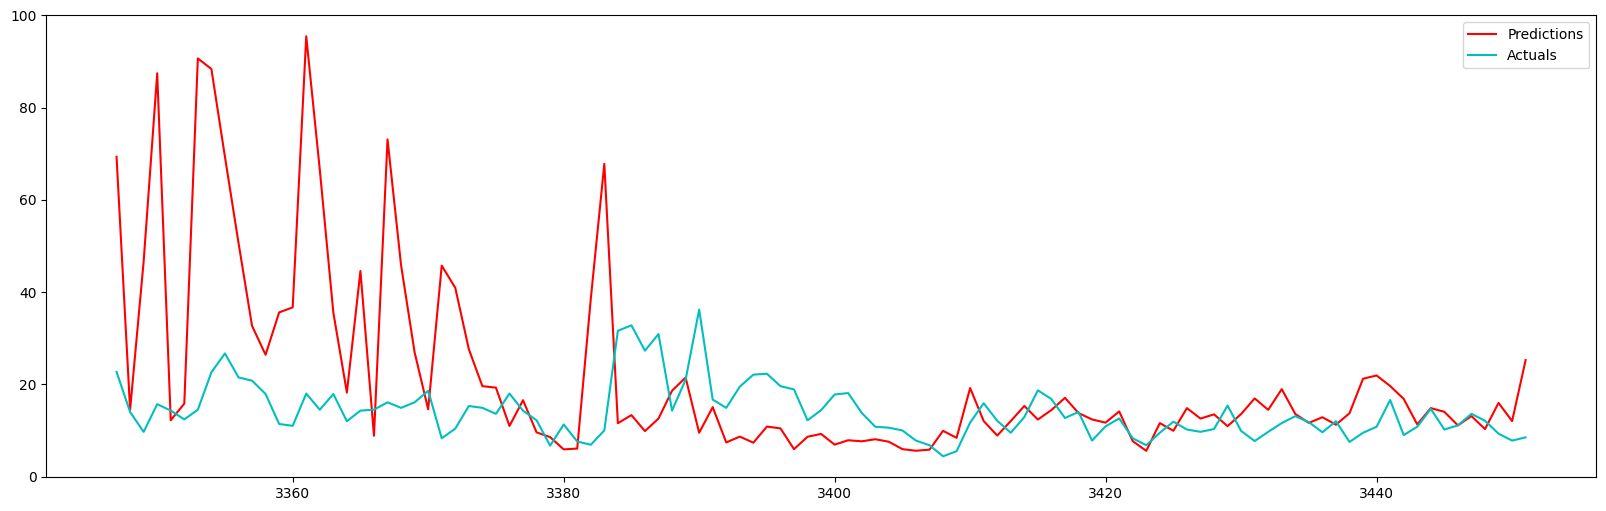

464.3637304545258
1/1 [==============================] - 0s 21ms/step


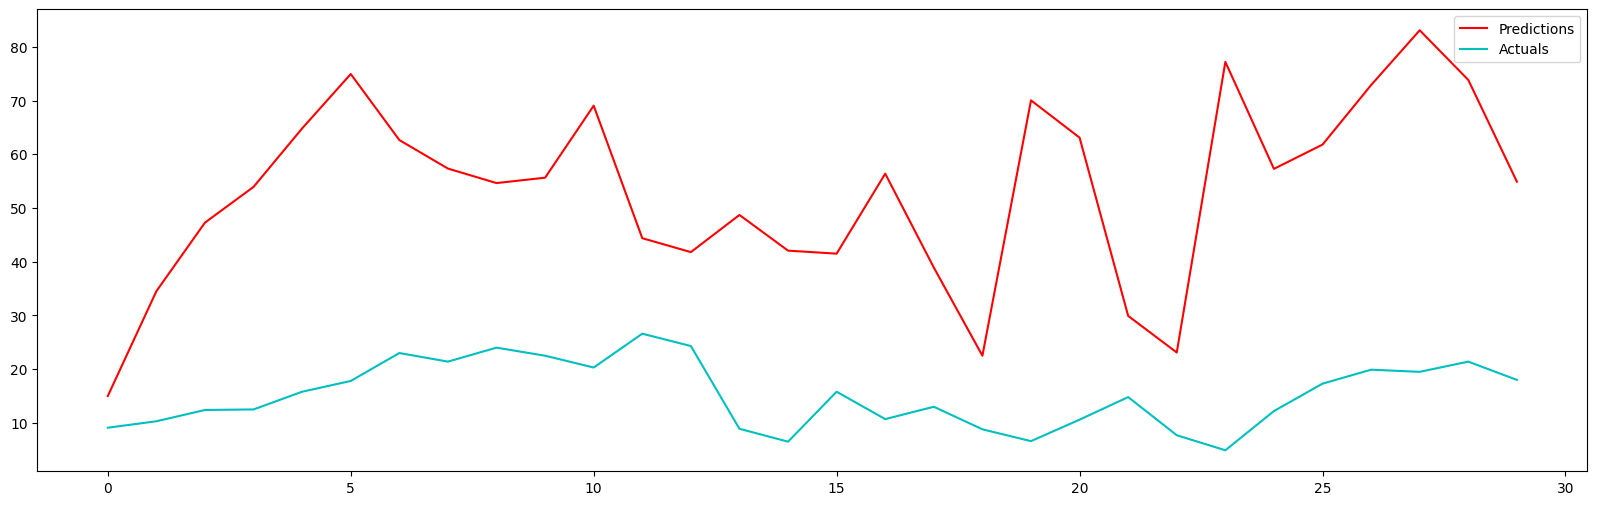

Procent dobrze przewidzianych: 3.33%


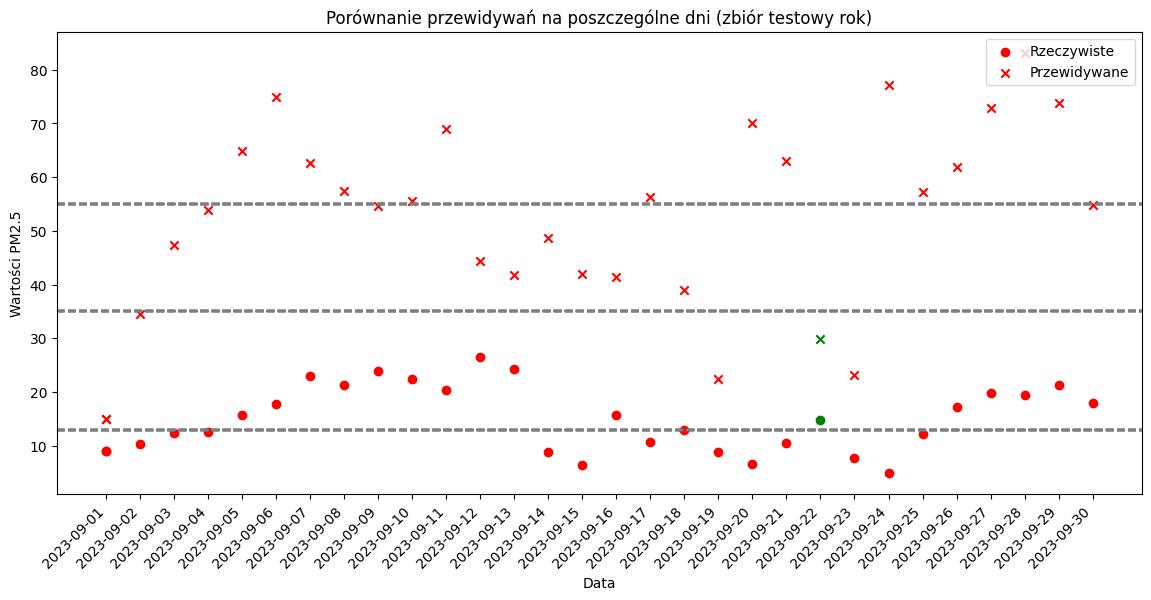

skuteczność:


In [23]:
from tensorflow.keras.models import load_model
loaded_model = load_model('model21/')

plot_predictions1(loaded_model, X_test_scaled.reshape((X_test_scaled.shape[0], 1, input_dim)), y_test)

plt.show()


predictions = loaded_model.predict(X_train_scaled.reshape((X_train_scaled.shape[0], 1, 6))).flatten()
df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y_train})
plt.plot(df['Predictions'][0:3347], label='Predictions',color='r',linewidth=0.5)
plt.plot(df['Actuals'][0:3347], label='Actuals',color='c',linewidth=0.5)
plt.legend()
plt.show()
predictions = loaded_model.predict(X_val_scaled.reshape((X_val_scaled.shape[0], 1, 6))).flatten()
df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y_val})
plt.plot(df['Predictions'][0:105], label='Predictions',color='r')
plt.plot(df['Actuals'][0:105], label='Actuals',color='c')
plt.legend()
plt.show()
print(mse(predictions, y_val))

def plot_predictions1(model, X, y, start=0, end=32):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end], label='Predictions',color='r')
  plt.plot(df['Actuals'][start:end], label='Actuals',color='c')

  plt.legend()
  plt.show()
  return df, mse(predictions, y)


model_data_test = pd.read_csv("../../przygotowanie_danych/model_data_test.csv")
df2 = model_data_test.drop(model_data_test.columns[[0,1,2,3,4]],axis = 1)
model_data_test = df2
model_data_test.describe()
model_data_test

X_test_test = model_data_test[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y_test_test = model_data_test['PM2.5']

X_test_test_scaled = scaler.transform(X_test_test)

predictions = loaded_model.predict(X_test_test_scaled.reshape((X_test_test_scaled.shape[0], 1, 6))).flatten()
df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y_test_test})
plt.plot(df['Predictions'][0:3347], label='Predictions',color='r')
plt.plot(df['Actuals'][0:3347], label='Actuals',color='c')
plt.legend()
plt.show()




def ocen_jakosc_powietrza(rzeczywiste, przewidywane):
    prog_bardzo_dobry = 12
    prog_dobry = 35
    prog_umiarkowany = 55
    prog_dostateczny = 75
    prog_zly = 110

    kategorie = {
        'bardzo_dobry': (0, prog_bardzo_dobry),
        'dobry': (prog_bardzo_dobry + 0.1, prog_dobry),
        'umiarkowany': (prog_dobry + 0.1, prog_umiarkowany),
        'dostateczny': (prog_umiarkowany + 0.1, prog_dostateczny),
        'zly': (prog_dostateczny + 0.1, prog_zly),
        'bardzo_zly': (prog_zly + 0.1, float('inf'))
    }

    def przyporzadkuj_kategorie(wartosc):
        for kategoria, (min_prog, max_prog) in kategorie.items():
            if min_prog <= wartosc <= max_prog:
                return kategoria

    rzeczywista_kategoria = przyporzadkuj_kategorie(rzeczywiste)
    przewidziana_kategoria = przyporzadkuj_kategorie(przewidywane)

    return rzeczywista_kategoria, przewidziana_kategoria


# Przykładowe dane - zastąp tym odpowiednimi danymi
results = pd.DataFrame({
    'Data': pd.date_range(start='2023-09-01', periods=30),
    'Rzeczywiste wartości (y_test)': y_test_test,
    'Przewidywane wartości (y_pred)': predictions
})

# Dodaj kolumny kategorii i porównania
results['Rzeczywista kategoria'], results['Przewidziana kategoria'] = zip(*results.apply(lambda row: ocen_jakosc_powietrza(row['Rzeczywiste wartości (y_test)'], row['Przewidywane wartości (y_pred)']), axis=1))
results['Zgadza się'] = results['Rzeczywista kategoria'] == results['Przewidziana kategoria']
legend_added = False  # Dodaj legendę tylko raz

# Wyodrębnij unikalne daty
unikalne_daty = results['Data'].unique()


procent_poprawnych = results['Zgadza się'].mean() * 100
print(f"Procent dobrze przewidzianych: {procent_poprawnych:.2f}%")


plt.figure(figsize=(14, 6))
sns.set_palette("Set2")  # Wybierz zestaw kolorów
for data in unikalne_daty:
    dane_dnia = results[results['Data'] == data]
    color = 'green' if dane_dnia['Zgadza się'].all() else 'red'
    
    
    if not legend_added:
        
        plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'],label='Rzeczywiste', color=color, marker='o')
        plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'], label='Przewidywane',color=color, marker='x')
        legend_added = True

    plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'], color=color, marker='o')
    plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'],color=color, marker='x')

    progi_jakosci_powietrza = [13, 35, 55]
    for prog in progi_jakosci_powietrza:
        plt.axhline(y=prog, color='gray', linestyle='--')
plt.legend(loc='upper right')
plt.title('Porównanie przewidywań na poszczególne dni (zbiór testowy rok)')
plt.xlabel('Data')
plt.ylabel('Wartości PM2.5')
plt.xticks(ticks=unikalne_daty, labels=[data.strftime('%Y-%m-%d') for data in unikalne_daty], rotation=45, ha='right')
plt.show()
print("skuteczność:",)


